In [4]:
from torchvision import datasets, transforms
import torch
import numpy as np
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm

batch_size = 64
train_loader = torch.utils.data.DataLoader(
datasets.MNIST('./data',
    train=True,
    download = True,
    transform = transforms.Compose(
        [transforms.ToTensor()])
     ),
     batch_size=batch_size
)

test_dataset= datasets.MNIST('./data',
    train=False,
    transform=transforms.Compose(
    [transforms.ToTensor()])
    )

new_test = []
for i, (elem, y) in enumerate(test_dataset):
  new_test.append(elem.view(-1,784).reshape(-1))
new_test = torch.stack(new_test, dim=0).numpy()
new_test.shape


(10000, 784)

In [7]:
#borrowed from https://github.com/odie2630463/Restricted-Boltzmann-Machines-in-pytorch/blob/master/RBM.ipynb
class RBM(nn.Module):
    def __init__(self,
                 n_vis=784,
                 n_hin=500,
                 k=5):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hin))
        self.k = k
    
    def sample_from_p(self,p):
        return torch.relu(torch.sign(p - Variable(torch.rand(p.size()))))
    
    def v_to_h(self,v):
        p_h = torch.sigmoid(F.linear(v,self.W,self.h_bias))
        sample_h = self.sample_from_p(p_h)
        return p_h,sample_h
    
    def h_to_v(self,h):
        p_v = torch.sigmoid(F.linear(h,self.W.t(),self.v_bias))
        sample_v = self.sample_from_p(p_v)
        return p_v,sample_v
        
    def forward(self,v):
        pre_h1,h1 = self.v_to_h(v)
        
        h_ = h1
        for _ in range(self.k):
            pre_v_,v_ = self.h_to_v(h_)
            pre_h_,h_ = self.v_to_h(v_)
        
        return v,v_
    
    def free_energy(self,v):
        vbias_term = v.mv(self.v_bias)
        wx_b = F.linear(v,self.W,self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()

def train_rbm(input_dim, hidden_dim, lr, decay, epochs):
  torch.set_default_tensor_type('torch.cuda.FloatTensor')
  rbm = RBM(n_vis=input_dim, n_hin=hidden_dim)
  rbm.cuda()
  train_op = optim.SGD(rbm.parameters(), lr)
  total = len(train_loader)
  torch.backends.cudnn.benchmark = True
  with tqdm(total=total) as pbar:
    test_losses = []
    for epoch in range(epochs):
        print('epoch')
        loss_ = []
        for _, (data, y) in enumerate(train_loader):
            data = Variable(data.view(-1,input_dim)).cuda()
            sample_data = data.bernoulli()
            
            v,v1 = rbm(sample_data)
            l2_reg = torch.tensor(0., requires_grad=True)
            l2_lambda = decay
            
            
            for name, param in rbm.named_parameters():
              if 'W' in name:
                l2_reg = l2_reg + torch.norm(param, 1)
              reg_loss = l2_lambda * l2_reg
            loss = rbm.free_energy(v) - rbm.free_energy(v1) + reg_loss
            #loss_.append(loss.data[0])
            loss_.append(loss.item())
            train_op.zero_grad()
            loss.backward()
            train_op.step()
            pbar.update(1)
            if _ % 1000 == 0:
              print(np.mean(loss_))
              
        
    return rbm

In [9]:
#borrowed from https://github.com/wmingwei/restricted-boltzmann-machine-deep-belief-network-deep-boltzmann-machine-in-pytorch/blob/master/RBM/ais.py
from joblib import Parallel, delayed
import multiprocessing

def logp(rbm, v, step = 1000, M = 100, parallel = False, mean_logp = True):
    
    if mean_logp:
        return -np.mean(free_energy(v, rbm.W.cpu().data.numpy().T, rbm.h_bias.cpu().data.numpy(), rbm.v_bias.cpu().data.numpy()))-ais(rbm, step = step, M = M, parallel = parallel)
    else:
        return -free_energy(v, rbm.W.cpu().data.numpy().T, rbm.h_bias.cpu().data.numpy(), rbm.v_bias.cpu().data.numpy())-ais(rbm, step = step, M = M, parallel = parallel)
    
def ais(rbm, step = 100, M = 100, parallel = False, seed = None):

    W = rbm.W.cpu().data.numpy().T
    v_bias = rbm.v_bias.cpu().data.numpy()
    h_bias = rbm.h_bias.cpu().data.numpy()
    
    logZ0 = np.log((1+np.exp(v_bias))).sum() + np.log(1+np.exp(h_bias)).sum()
    ratio = []
    if parallel:
        num_cores = multiprocessing.cpu_count()

        results = Parallel(n_jobs=num_cores)(delayed(mcmc)(step = step, seed = seed, W = W, h_bias = h_bias, v_bias = v_bias) for i in range(M))


        results = np.array(results).reshape(len(results), 1)
        logZ = logZ0 + logmeanexp(results, axis = 0)
    else:
        for i in range(M):
            ratio.append(mcmc(step, seed = seed,  W = W, h_bias = h_bias, v_bias = v_bias))

        ratio = np.array(ratio).reshape(len(ratio),1)
        logZ = logZ0 + logmeanexp(ratio, axis = 0)

    return logZ

def mcmc(step, seed, W, h_bias, v_bias):

    np.random.seed(seed)

    v = np.random.binomial(1, p=1/(1+np.exp(-v_bias))).reshape(1,-1)

    logw = 0
    for k in range(step):
        logp_k = -free_energy(v, k*1.0/step*W, h_bias, v_bias)
        logp_k1 = -free_energy(v, (k+1)*1.0/step*W, h_bias, v_bias)
        logw += logp_k1 - logp_k

        
        p_h, h = v_to_h(v, (k+1)*1.0/step*W, h_bias)
        p_v, v = h_to_v(h, (k+1)*1.0/step*W, v_bias)

    return logw


def v_to_h(v, W, h_bias):

    activation = np.clip(np.matmul(v,W) + h_bias,-80,80)
    p_h = 1/(1+np.exp(-activation))
    h = np.random.binomial(1, p=p_h)

    return p_h, h


def h_to_v(h, W, v_bias):

    activation = np.clip(np.matmul(h, W.T) + v_bias,-80,80)
    p_v = 1/(1+np.exp(-activation))
    v = np.random.binomial(1, p=p_v)
    return p_v, v

def free_energy(v, W, h_bias, v_bias):

    Wv = np.clip(np.matmul(v,W) + h_bias,-80,80)
    hidden = np.log(1+np.exp(Wv)).sum(1)
    vbias = np.matmul(v, v_bias.T).reshape(hidden.shape)
    return -hidden-vbias


def logmeanexp(x, axis=None):
    
    x = np.asmatrix(x)
    if not axis:
        n = len(x)
    else:
        n = x.shape[axis]
    
    x_max = x.max(axis)
    return (x_max + np.log(np.exp(x-x_max).sum(axis)) - np.log(n)).A



  1%|          | 10/938 [00:00<00:09, 97.41it/s]

epoch
7.37829065322876


956it [00:09, 97.32it/s]

epoch
-13.971565246582031


1891it [00:19, 99.40it/s]

epoch
-12.538549423217773


2828it [00:28, 97.90it/s]

epoch
-11.977149963378906


3752it [00:38, 97.79it/s]
  1%|          | 10/938 [00:00<00:10, 90.44it/s]

epoch
26.182172775268555


954it [00:09, 94.88it/s]

epoch
-10.493099212646484


1889it [00:19, 98.87it/s]

epoch
-7.766204833984375


2826it [00:29, 99.30it/s]

epoch
-5.660499572753906


3752it [00:38, 97.21it/s]
  1%|          | 10/938 [00:00<00:09, 97.62it/s]

epoch
44.08791732788086


948it [00:09, 96.97it/s]                         

epoch
-4.192356109619141


1886it [00:19, 97.39it/s]

epoch
-5.342739105224609


2824it [00:29, 97.46it/s]

epoch
-1.8393669128417969


3752it [00:38, 96.70it/s]
  1%|          | 10/938 [00:00<00:09, 95.43it/s]

epoch
62.92298126220703


951it [00:10, 93.77it/s]

epoch
5.169757843017578


1891it [00:19, 95.87it/s]

epoch
-0.3443870544433594


2824it [00:29, 95.70it/s]

epoch
19.4481201171875


3752it [00:39, 95.57it/s]
  1%|          | 10/938 [00:00<00:10, 92.61it/s]

epoch
87.84007263183594


953it [00:09, 95.78it/s]

epoch
13.60416030883789


1893it [00:19, 94.98it/s]

epoch
19.599163055419922


2833it [00:29, 96.70it/s]

epoch
6.550453186035156


3752it [00:39, 95.99it/s]
  1%|          | 9/938 [00:00<00:10, 86.69it/s]

epoch
101.13887023925781


949it [00:09, 97.33it/s]

epoch
15.301887512207031


1886it [00:19, 100.33it/s]

epoch
8.887470245361328


2832it [00:28, 97.27it/s]

epoch
29.412986755371094


3752it [00:38, 97.97it/s]
  1%|          | 9/938 [00:00<00:11, 82.62it/s]

epoch
125.18467712402344


949it [00:09, 96.53it/s]

epoch
24.03795623779297


1891it [00:19, 96.29it/s]

epoch
19.74658203125


2825it [00:29, 96.45it/s]

epoch
27.885791778564453


3752it [00:39, 96.15it/s]
  1%|          | 9/938 [00:00<00:10, 88.44it/s]

epoch
137.6641845703125


955it [00:09, 97.34it/s]

epoch
33.60738754272461


1888it [00:19, 98.13it/s]

epoch
54.79983901977539


2825it [00:29, 97.92it/s]

epoch
53.30837631225586


3752it [00:38, 97.06it/s]


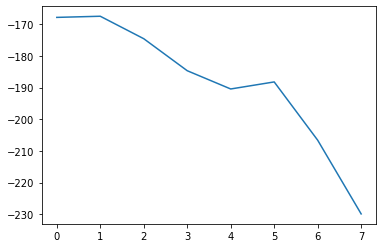

In [19]:
#lets plot the ais on the test set over a range models trained for different numbers of epochs (10 models, epochs: 1-10)
import matplotlib.pyplot as plt
test_data = new_test
log_p_tests = []
hidden_sizes = np.linspace(100, 2000, 8)
for i in range(hidden_sizes.size):
  rbm = train_rbm(784, int(hidden_sizes[i]), .01, .01, 4)
  logp_result = logp(rbm, test_data, step = 100, M = 100, parallel = True, mean_logp = True)
  log_p_tests.append(logp_result)
  del rbm
  torch.cuda.empty_cache()

log_array = np.asarray(log_p_tests).reshape(-1)
plt.plot(log_array)
#the ais seems to increase as expected with further training.

In [15]:
for i in range(10):
  print(i)

0
1
2
3
4
5
6
7
8
9
